Data starts at: 39.88 s


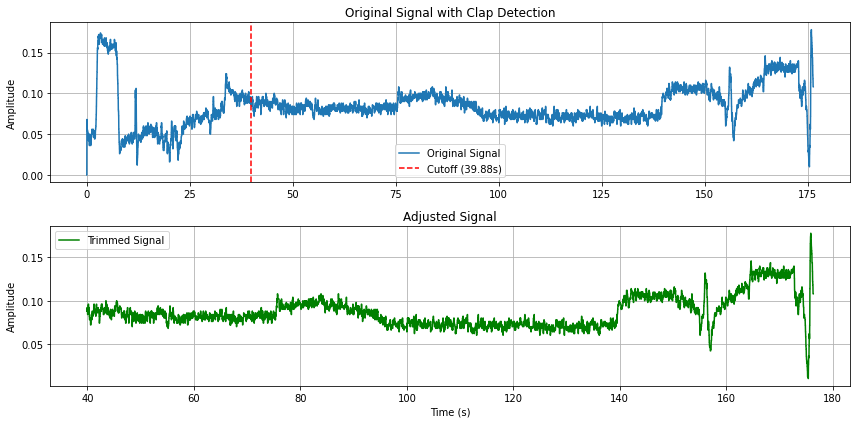

44088


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import csv

# Configuration
FILE_PATH = '/Users/daryanfadavi/Downloads/datasets/2_FA/2_FA_3.txt'
CHANNEL = 'Accel Channel 2' # Which channel to look at
SPIKE_OFFSET = 0  # Number of points to skip after detected noise
BASELINE_WINDOW = 40000  # Samples for noise baseline calculation
THRESHOLD_MULTIPLIER = 5  # Multiplier for noise threshold

def load_data(file_path):
    with open(file_path) as f:
        headers = [next(f) for _ in range(4)]
        actual_header = f.readline().strip()
    
    # Clean column names to ensure uniqueness
    columns = [col.strip() for col in actual_header.split(',')]
    columns = [f"{col}_{i}" if columns[:i].count(col) > 0 else col 
               for i, col in enumerate(columns)]
    
    # Load data
    df = pd.read_csv(file_path, skiprows=5, names=columns)
    
    return df, headers

def trim_signal(signal, fs=250):
    # Calculate baseline noise
    baseline_signal = signal[:BASELINE_WINDOW]
    baseline_std = np.std(baseline_signal)
    threshold = np.median(baseline_signal) + THRESHOLD_MULTIPLIER * baseline_std

    # Find peaks with minimum prominence
    peaks, _ = find_peaks(signal, height=threshold, prominence=baseline_std*3)
    
    if len(peaks) > 0:
        if peaks[0] > 9970:
            cutoff_idx = 9970
        else:
            cutoff_idx = peaks[0]
    else:
        cutoff_idx = 9970

    # Trim data
    trimmed_signal = signal[cutoff_idx:cutoff_idx + 37500]
    
    return trimmed_signal, cutoff_idx
    
def separate_signal(signal):
    separated_signals = []
    i = 0
    
    while i < 362251:
        separated_signals.append(signal[i:i+1250])
        i += 1250
    
    return separated_signals

def save_to_csv(separated, base_filename="MB_data"):
    for i, array in enumerate(separated):
        # Convert the array to a DataFrame
        df = pd.DataFrame(array)
        
        # Define the filename
        filename = f"{base_filename}_{i}.csv"
        
        # Save to CSV
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")

def plot_signals(original_sig, trimmed_sig, cutoff_idx, fs=250):
    """Plot comparison of original and trimmed signals"""
    plt.figure(figsize=(12, 6))
    
    # Original signal plot
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(original_sig))/fs, original_sig, label='Original Signal')
    plt.axvline(cutoff_idx/fs, color='r', linestyle='--', 
              label=f'Cutoff ({cutoff_idx/fs:.2f}s)')
    plt.title('Original Signal with Clap Detection')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # Trimmed signal plot
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(trimmed_sig))/fs + cutoff_idx/fs, 
           trimmed_sig, color='g', label='Trimmed Signal')
    plt.title('Adjusted Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # Load data
    df, headers = load_data(FILE_PATH)
    
    # Detect spike
    signal = df[CHANNEL].values
    

    trimmed_signal, cutoff = trim_signal(signal)
    separated = separate_signal(trimmed_signal)

    print(f"Data starts at: {cutoff/250:.2f} s")
    
    # Generate plots
    plot_signals(signal, trimmed_signal, cutoff)
    
    print(len(signal))
    
    # save_to_csv(separated)
    
    

if __name__ == "__main__":
    main()